## Low-level benchmarks

The code in this notebook should be run from the base SHEEP directory, and relies on an sqlite file called sheep.db being present in the frontend/ subdirectory.
Dependencies are:
* pandas
* numpy
* matplotlib
* sqlalchemy

In [57]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


Import some SQLAlchemy utilities from the SHEEP frontend code.

In [58]:
from frontend.database import BenchmarkMeasurement, session
from frontend.database import build_filter

How long do nested ADDITIONS take in each library on boolean inputs? (In the below, the "depth" value represents the number of the selected operations performed).

In [63]:
all_rows = pd.read_sql(session.query(BenchmarkMeasurement).statement,session.bind)
all_rows.head()


,id,context_name,input_bitwidth,input_signed,gate_name,depth,num_slots,num_threads,parameters,execution_time,is_correct
0,1,HElib_F2,1,False,ADD,1,1,1,Default,0.000,True
1,2,HElib_Fp,1,False,ADD,1,1,1,Default,0.000,True
2,3,TFHE,1,False,ADD,1,1,1,Default,0.023,True
3,4,HElib_F2,1,False,ADD,2,1,1,Default,0.001,True
4,5,HElib_Fp,1,False,ADD,2,1,1,Default,0.000,True


In [60]:
add_bool_inputs = all_rows[(all_rows.input_bitwidth==1) & (all_rows.gate_name=="ADD")]

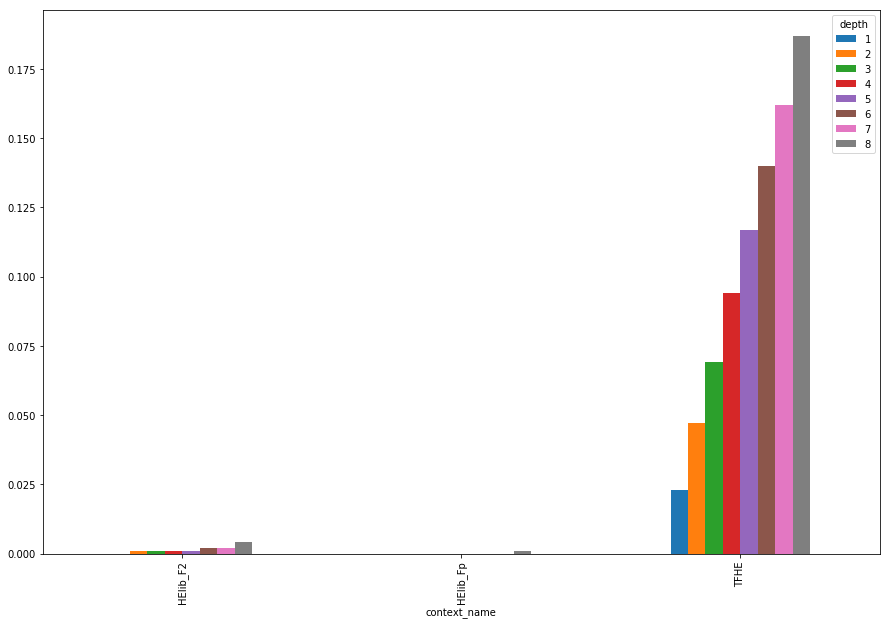

In [61]:
ax = add_bool_inputs.pivot(index='context_name', columns='depth', values='execution_time').plot(kind='bar',figsize=(15,10),legend=True)
plt.show()

For HElib_F2, how do the different operations scale with input bitwidth? 

In [68]:
helibf2_depth1 = all_rows[(all_rows.context_name=="HElib_F2")&(all_rows.input_signed==0)&(all_rows.depth==1)]

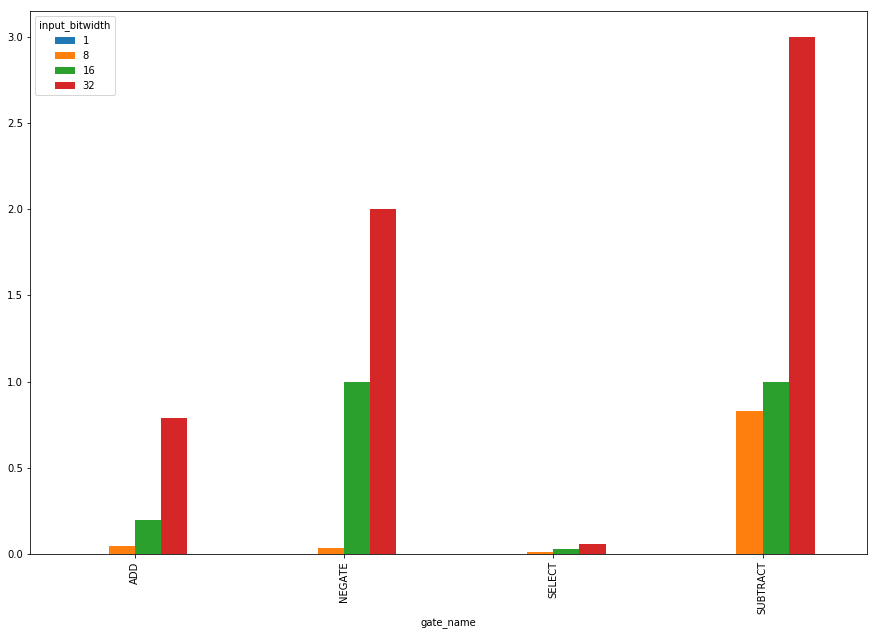

In [69]:
ax = helibf2_depth1.pivot(index='gate_name', columns='input_bitwidth', values='execution_time').plot(kind='bar',figsize=(15,10),legend=True)
plt.show()

Same for HElib_Fp

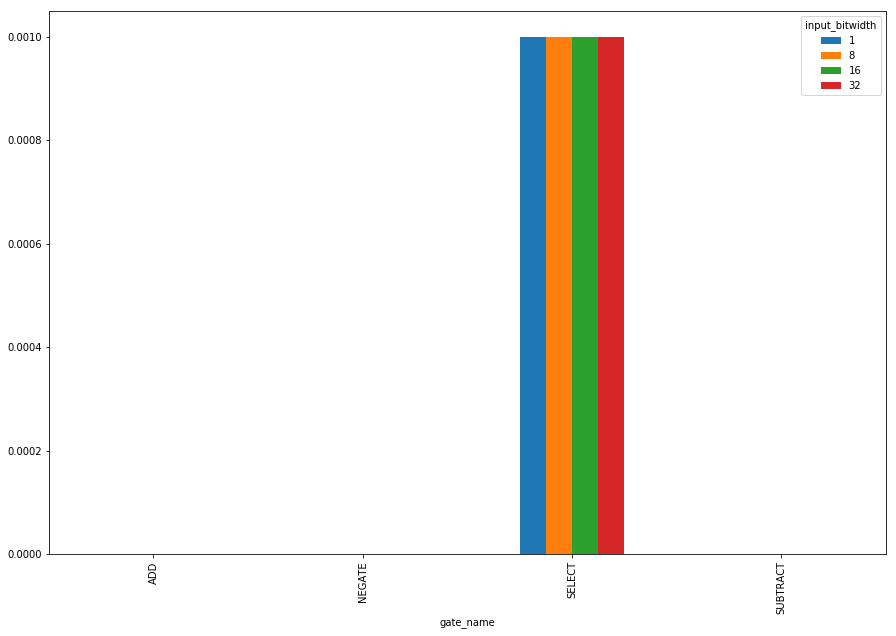

In [70]:
helibfp_depth1 = all_rows[(all_rows.context_name=="HElib_Fp")&(all_rows.input_signed==0)&(all_rows.depth==1)]
ax = helibfp_depth1.pivot(index='gate_name', columns='input_bitwidth', values='execution_time').plot(kind='bar',figsize=(15,10),legend=True)
plt.show()

And for TFHE

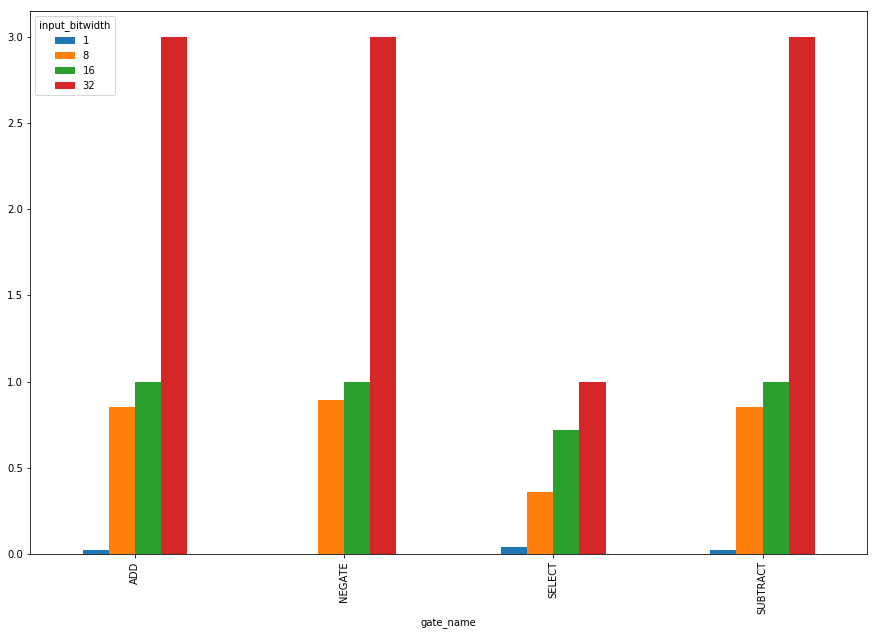

In [72]:
tfhe_depth1 = all_rows[(all_rows.context_name=="TFHE")&(all_rows.input_signed==0)&(all_rows.depth==1)]
ax = tfhe_depth1.pivot(index='gate_name', columns='input_bitwidth', values='execution_time').plot(kind='bar',figsize=(15,10),legend=True)
plt.show()